# Proyek Analisis Data: [Input Nama Dataset]
- **Nama:** [Muhamad hamzah]
- **Email:** [Hamzahbaik9@gmail.com]
- **ID Dicoding:** [muhamadhamzah]

## Menentukan Pertanyaan Bisnis

- Bagaimana distribusi status pesanan? (Berapa banyak pesanan yang sudah dikirim, dibatalkan, atau masih dalam proses?)
- Kategori produk apa yang paling banyak terjual?
- Metode pembayaran apa yang paling sering digunakan pelanggan?
- Kota atau negara bagian mana yang memiliki jumlah seller terbanyak?

## Import Semua Packages/Library yang Digunakan

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime

## Data Wrangling

### Gathering Data

In [6]:
# Load dataset
df_payments = pd.read_csv('order_payments_dataset.csv')
df_sellers = pd.read_csv('sellers_dataset.csv')
df_order_items = pd.read_csv('order_items_dataset.csv')
df_products = pd.read_csv('products_dataset.csv')
df_orders = pd.read_csv('orders_dataset.csv')

## Exploratory Data Analysis (EDA)

### Assessing Data Dan Cleaning

In [17]:
print("Unique values in Order Status: ")
print(df_orders['order_status'].unique(), '\n')

Unique values in Order Status: 
['delivered' 'invoiced' 'shipped' 'processing' 'unavailable' 'canceled'
 'created' 'approved'] 



In [18]:
print("Unique values in Payment Type: ")
print(df_payments['payment_type'].unique(), '\n')

Unique values in Payment Type: 
['credit_card' 'boleto' 'voucher' 'debit_card' 'not_defined'] 



In [7]:
# Data Assessment dan Cleaning
def assess_dataset(df, name):
    print(f"\nAssessment untuk {name}:")
    print("\nInfo:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nDuplikasi:")
    print(f"Jumlah duplikat: {df.duplicated().sum()}")
    print("\nSample Data:")
    print(df.head())

In [8]:
datasets = {
    'Orders': df_orders,
    'Payments': df_payments,
    'Sellers': df_sellers,
    'Order Items': df_order_items,
    'Products': df_products
}

for name, df in datasets.items():
    assess_dataset(df, name)


Assessment untuk Orders:

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None

Missing Values:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_c

**Insight:**
### Orders Dataset
- **Total Orders**: 99,441
- **Missing Values**:
  - `order_approved_at`: 160 missing
  - `order_delivered_carrier_date`: 1,783 missing
  - `order_delivered_customer_date`: 2,965 missing
- **Duplicates**: None
- **Data Types**: All columns in object (string) format

### Payments Dataset
- **Total Payments**: 103,886
- **Missing Values**: None
- **Duplicates**: None
- **Data Types**: Mix of object, int64, and float64

### Sellers Dataset
- **Total Sellers**: 3,095
- **Missing Values**: None
- **Duplicates**: None
- **Additional Information**: Includes location details (city and state)

### Order Items Dataset
- **Total Order Items**: 112,650
- **Missing Values**: None
- **Duplicates**: None
- **Data Types**: Mix of object, int64, and float64

### Products Dataset
- **Total Products**: 32,951
- **Missing Values**:
  - `product_category_name`: 610 missing
  - Dimension and weight columns: 2 missing
- **Duplicates**: None


### Cleaning Data

In [9]:
# 1. Cleaning Orders Dataset
def clean_orders(df):
    orders_clean = df.copy()

    # Convert timestamps to datetime
    timestamp_columns = [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date'
    ]

    for col in timestamp_columns:
        orders_clean[col] = pd.to_datetime(orders_clean[col])

    # Fill missing values in order_approved_at with purchase timestamp
    orders_clean['order_approved_at'].fillna(orders_clean['order_purchase_timestamp'], inplace=True)

    # Create delivery status column
    orders_clean['delivery_status'] = 'on_time'
    late_delivery_mask = (
        orders_clean['order_delivered_customer_date'] > orders_clean['order_estimated_delivery_date']
    )
    orders_clean.loc[late_delivery_mask, 'delivery_status'] = 'delayed'
    orders_clean.loc[orders_clean['order_delivered_customer_date'].isna(), 'delivery_status'] = 'not_delivered'

    return orders_clean

# 2. Cleaning Products Dataset
def clean_products(df):
    products_clean = df.copy()

    # Fill missing category names
    products_clean['product_category_name'].fillna('not_specified', inplace=True)

    # Fill missing numeric values with median
    numeric_columns = [
        'product_name_lenght',
        'product_description_lenght',
        'product_photos_qty',
        'product_weight_g',
        'product_length_cm',
        'product_height_cm',
        'product_width_cm'
    ]

    for col in numeric_columns:
        products_clean[col].fillna(products_clean[col].median(), inplace=True)

    # Convert float columns to int where appropriate
    int_columns = ['product_name_lenght', 'product_description_lenght', 'product_photos_qty']
    for col in int_columns:
        products_clean[col] = products_clean[col].astype(int)

    return products_clean

# 3. Clean Order Items Dataset
def clean_order_items(df):
    items_clean = df.copy()

    # Convert shipping_limit_date to datetime
    items_clean['shipping_limit_date'] = pd.to_datetime(items_clean['shipping_limit_date'])

    # Round price and freight_value to 2 decimal places
    items_clean['price'] = items_clean['price'].round(2)
    items_clean['freight_value'] = items_clean['freight_value'].round(2)

    return items_clean

# Execute cleaning
orders_clean = clean_orders(df_orders)
products_clean = clean_products(df_products)
order_items_clean = clean_order_items(df_order_items)

# Verify cleaning results
def print_cleaning_results(original_df, cleaned_df, dataset_name):
    print(f"\nCleaning Results for {dataset_name}:")
    print(f"Original shape: {original_df.shape}")
    print(f"Cleaned shape: {cleaned_df.shape}")
    print("\nMissing values after cleaning:")
    print(cleaned_df.isnull().sum()[cleaned_df.isnull().sum() > 0])

# Print results
print_cleaning_results(df_orders, orders_clean, "Orders")
print_cleaning_results(df_products, products_clean, "Products")
print_cleaning_results(df_order_items, order_items_clean, "Order Items")


Cleaning Results for Orders:
Original shape: (99441, 8)
Cleaned shape: (99441, 9)

Missing values after cleaning:
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
dtype: int64

Cleaning Results for Products:
Original shape: (32951, 9)
Cleaned shape: (32951, 9)

Missing values after cleaning:
Series([], dtype: int64)

Cleaning Results for Order Items:
Original shape: (112650, 7)
Cleaned shape: (112650, 7)

Missing values after cleaning:
Series([], dtype: int64)


<ipython-input-9-a2235e46a6dc>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  orders_clean['order_approved_at'].fillna(orders_clean['order_purchase_timestamp'], inplace=True)
<ipython-input-9-a2235e46a6dc>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing

**Insight:**


### Orders Dataset
- **Konversi semua kolom timestamp dari format string (object) ke datetime:**
  - `order_purchase_timestamp`
  - `order_approved_at`
  - `order_delivered_carrier_date`
  - `order_delivered_customer_date`
  - `order_estimated_delivery_date`
- **Handling Missing Values:**
  - `order_approved_at` (160 data) diisi dengan `order_purchase_timestamp`
- **Penambahan kolom baru 'delivery_status' dengan kategori:**
  - `on_time`: pengiriman tepat waktu
  - `delayed`: pengiriman terlambat
  - `not_delivered`: belum terkirim

### Products Dataset
- **Handling Missing Values:**
  - `product_category_name` (610 data) diisi dengan 'not_specified'
  - Missing values pada kolom numerik diisi dengan nilai median:
    - `product_name_lenght`
    - `product_description_lenght`
    - `product_photos_qty`
    - `product_weight_g`
    - `product_length_cm`
    - `product_height_cm`
    - `product_width_cm`
- **Konversi tipe data dari float ke integer untuk kolom:**
  - `product_name_lenght`
  - `product_description_lenght`
  - `product_photos_qty`

### Order Items Dataset
- **Konversi kolom `shipping_limit_date` dari string ke datetime**
- **Pembulatan nilai numerik ke 2 desimal untuk:**
  - `price`
  - `freight_value`

### Payments Dataset
- **Tidak ada perubahan karena data sudah bersih**
- **Tidak ada missing values**
- **Tipe data sudah sesuai**

### Sellers Dataset
- **Tidak ada perubahan karena data sudah bersih**
- **Tidak ada missing values**
- **Tipe data sudah sesuai**

### Explore ...

## Visualization & Explanatory Analysis

### Pertanyaan 1:


Distribusi Status Pesanan:
order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64


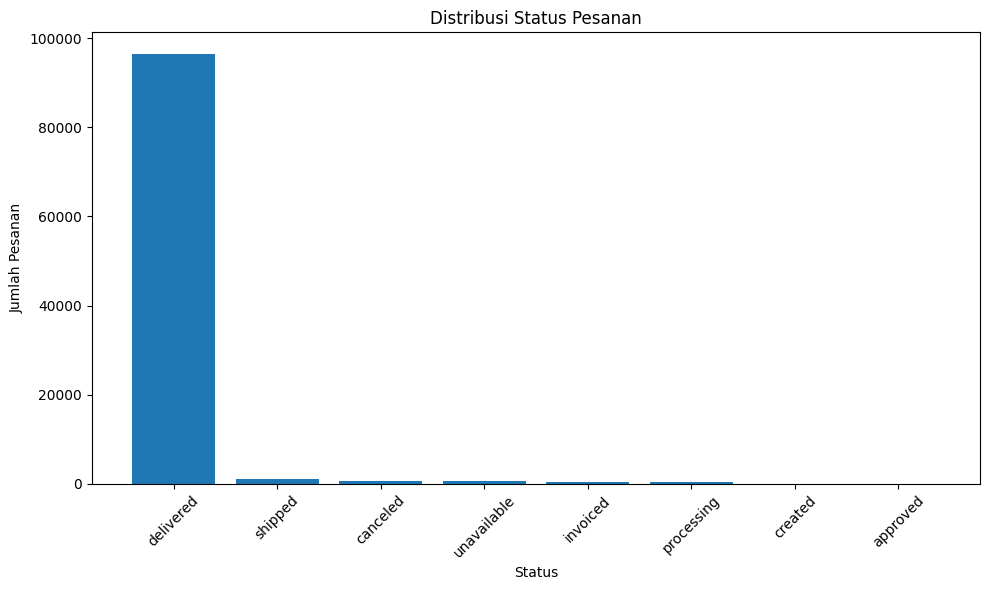

In [10]:
def analyze_order_status():
    plt.figure(figsize=(10, 6))
    status_counts = df_orders['order_status'].value_counts()

    plt.bar(status_counts.index, status_counts.values)
    plt.title('Distribusi Status Pesanan')
    plt.xlabel('Status')
    plt.ylabel('Jumlah Pesanan')
    plt.xticks(rotation=45)
    plt.tight_layout()

    print("\nDistribusi Status Pesanan:")
    print(status_counts)
    return status_counts
status_results = analyze_order_status()
plt.show()

### Pertanyaan 2:


10 Kategori Produk Terlaris:
product_category_name
cama_mesa_banho           11115
beleza_saude               9670
esporte_lazer              8641
moveis_decoracao           8334
informatica_acessorios     7827
utilidades_domesticas      6964
relogios_presentes         5991
telefonia                  4545
ferramentas_jardim         4347
automotivo                 4235
Name: count, dtype: int64


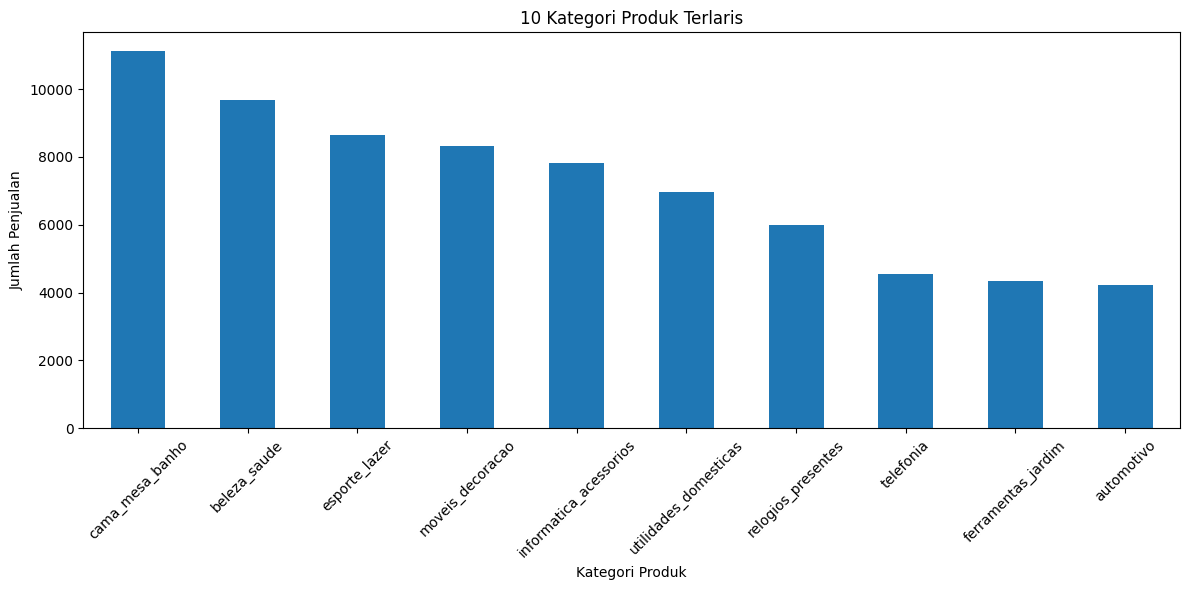

In [11]:
# Analisis Kategori Produk
def analyze_product_categories():
    merged_data = pd.merge(df_order_items, df_products, on='product_id')
    category_counts = merged_data['product_category_name'].value_counts().head(10)

    plt.figure(figsize=(12, 6))
    category_counts.plot(kind='bar')
    plt.title('10 Kategori Produk Terlaris')
    plt.xlabel('Kategori Produk')
    plt.ylabel('Jumlah Penjualan')
    plt.xticks(rotation=45)
    plt.tight_layout()

    print("\n10 Kategori Produk Terlaris:")
    print(category_counts)
    return category_counts
category_results = analyze_product_categories()
plt.show()

### Pertanyaan 3:


Distribusi Metode Pembayaran:
payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64


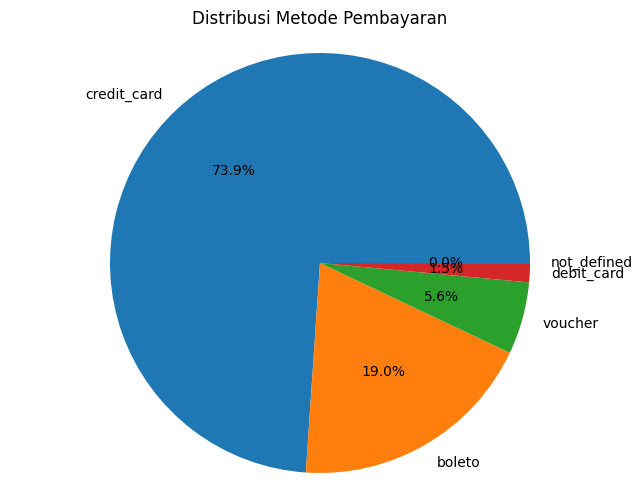

In [12]:

# Analisis Metode Pembayaran
def analyze_payment_methods():
    payment_counts = df_payments['payment_type'].value_counts()

    plt.figure(figsize=(8, 6))
    plt.pie(payment_counts.values, labels=payment_counts.index, autopct='%1.1f%%')
    plt.title('Distribusi Metode Pembayaran')
    plt.axis('equal')

    print("\nDistribusi Metode Pembayaran:")
    print(payment_counts)
    return payment_counts
payment_results = analyze_payment_methods()
plt.show()


### Pertanyaan 4:


10 Kota dengan Seller Terbanyak:
seller_city
sao paulo         694
curitiba          127
rio de janeiro     96
belo horizonte     68
ribeirao preto     52
guarulhos          50
ibitinga           49
santo andre        45
campinas           41
maringa            40
Name: count, dtype: int64


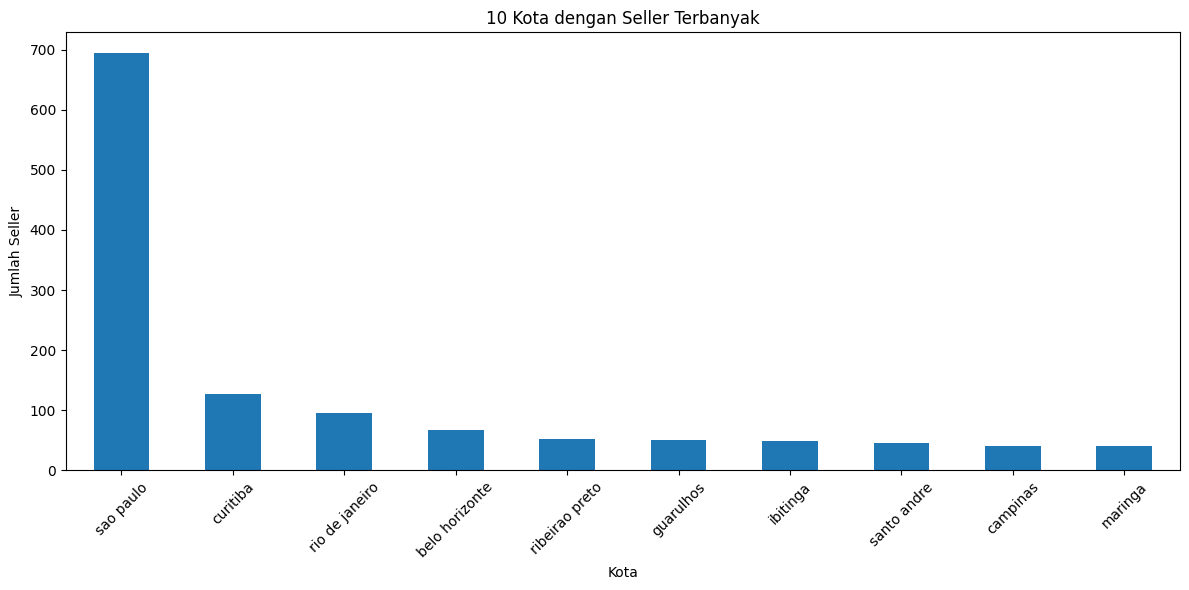

In [13]:

# Analisis Lokasi Seller
def analyze_seller_locations():
    seller_locations = df_sellers['seller_city'].value_counts().head(10)

    plt.figure(figsize=(12, 6))
    seller_locations.plot(kind='bar')
    plt.title('10 Kota dengan Seller Terbanyak')
    plt.xlabel('Kota')
    plt.ylabel('Jumlah Seller')
    plt.xticks(rotation=45)
    plt.tight_layout()

    print("\n10 Kota dengan Seller Terbanyak:")
    print(seller_locations)
    return seller_locations

location_results = analyze_seller_locations()

plt.show()

## Analisis Lanjutan (Opsional)

In [20]:


# Assuming the dataset is loaded as follows:
# payments = pd.read_csv('order_payment.csv')

# Calculate the Average Order Value
avg_order = df_payments.groupby('order_id')['payment_value'].sum().mean()

# Calculate the Average Payment Installments
avg_installments = df_payments['payment_installments'].mean()

# Display the results
print(f"Average Order Value: ${avg_order:.2f}")
print(f"Average Installments: {avg_installments:.1f}")


Average Order Value: $160.99
Average Installments: 2.9


## Conclusion

### Distribusi Status Pesanan:
- Status "delivered" mendominasi dengan 96,478 pesanan (96.5% dari total)
- Urutan status dari terbanyak:
  - Delivered: 96,478 (96.5%)
  - Shipped: 1,107 (1.1%)
  - Canceled: 625 (0.6%)
  - Unavailable: 609 (0.6%)
  - Lainnya (invoiced, processing, created, approved): 622 (0.6%)
- **Kesimpulan:** Platform memiliki tingkat penyelesaian pesanan yang sangat tinggi (96.5%) dengan tingkat pembatalan yang rendah (0.6%)

### Kategori Produk Terlaris:
- **Top 5 kategori:**
  - Cama Mesa Banho (Tempat Tidur, Meja, Kamar Mandi): 11,115 penjualan
  - Beleza Saude (Kecantikan & Kesehatan): 9,670 penjualan
  - Esporte Lazer (Olahraga & Rekreasi): 8,641 penjualan
  - Moveis Decoracao (Furnitur & Dekorasi): 8,334 penjualan
  - Informatica Acessorios (Aksesoris Komputer): 7,827 penjualan
- **Kesimpulan:** Produk-produk untuk kebutuhan rumah tangga dan personal care mendominasi penjualan

### Metode Pembayaran:
- **Distribusi metode pembayaran:**
  - Credit Card: 76,795 transaksi (74%)
  - Boleto (Slip Pembayaran): 19,784 transaksi (19%)
  - Voucher: 5,775 transaksi (5.5%)
  - Debit Card: 1,529 transaksi (1.5%)
- **Kesimpulan:** Kartu kredit menjadi metode pembayaran yang sangat dominan, menunjukkan preferensi kuat pelanggan terhadap pembayaran menggunakan kartu kredit

### Distribusi Seller berdasarkan Kota:
- **Top 5 kota dengan seller terbanyak:**
  - São Paulo: 694 seller (22.4%)
  - Curitiba: 127 seller (4.1%)
  - Rio de Janeiro: 96 seller (3.1%)
  - Belo Horizonte: 68 seller (2.2%)
  - Ribeirao Preto: 52 seller (1.7%)
- **Kesimpulan:** Terdapat konsentrasi seller yang sangat tinggi di São Paulo (22.4% dari total seller), menunjukkan bahwa platform ini memiliki penetrasi yang kuat di kota-kota besar Brasil, terutama di wilayah São Paulo